In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cvxpy as cp
import yfinance as yf

# Three High-Dimensional Models for Time Series

We shall discuss three simple high-dimensional models for time series. The first model was already studied in the previous week. The third model is the same as the spectrum model from last lecture (even though the presentation today will be slightly different). The second model has not been discussed before in this class but it is quite simple. 

## Model ONE

This is the model
\begin{equation*}
   y_t \overset{\text{ind}}{\sim} N(\mu_t, \sigma^2)
\end{equation*}
where $\mu_t$ (which can be interpreted as the trend function) is smooth in $t$. $\mu_t$ can be estimated from the data using one of the following two regularized estimators obtained by minimizing
\begin{equation*}
   \sum_{t=1}^n (y_t - \mu_t)^2 + \lambda \sum_{t=2}^{n-1} \left((\mu_t - \mu_{t-1}) - (\mu_{t-1} - \mu_t) \right)^2
\end{equation*}
or
\begin{equation*}
   \sum_{t=1}^n (y_t - \mu_t)^2 + \lambda \sum_{t=2}^{n-1} \left|(\mu_t - \mu_{t-1}) - (\mu_{t-1} - \mu_t) \right|
\end{equation*}
As we saw previously, these are the same as the estimators obtained by employing the ridge and LASSO penalties to the high-dimensional linear regression model: 
\begin{equation*}
   \mu_t = \beta_0 + \beta_1 (t-1) + \beta_2 (t-2)_+ + \dots + \beta_{n-1} (t - (n-1))_+
\end{equation*}

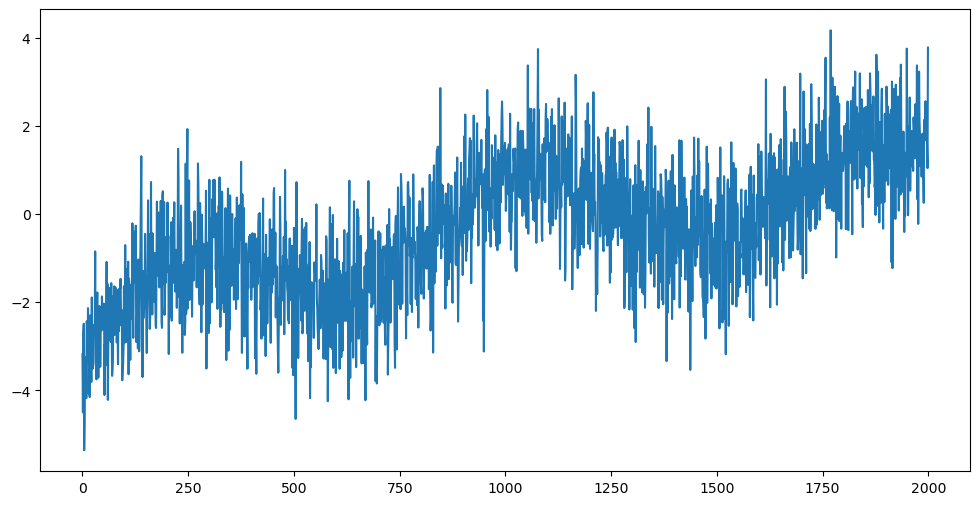

In [217]:
def smoothfun(x):
    ans = np.sin(15*x) + np.exp(-(x ** 2)/2) + 0.5*((x - 0.5) ** 2) + 2*np.log(x + 0.1)
    return ans

n = 2000
xx = np.linspace(0, 1, n)
mu_true = np.array([smoothfun(x) for x in xx])
sig = 1
rng = np.random.default_rng(seed = 42)
errorsamples = rng.normal(loc = 0, scale = sig, size = n)
y = mu_true + errorsamples
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()


Below we compute the estimator $\hat{\mu}_t$ directly without going to the regression representation (with the $X$ matrix that we previously used). We use the optimization functions from cvxpy directly on the optimization in terms of $\mu_t$.

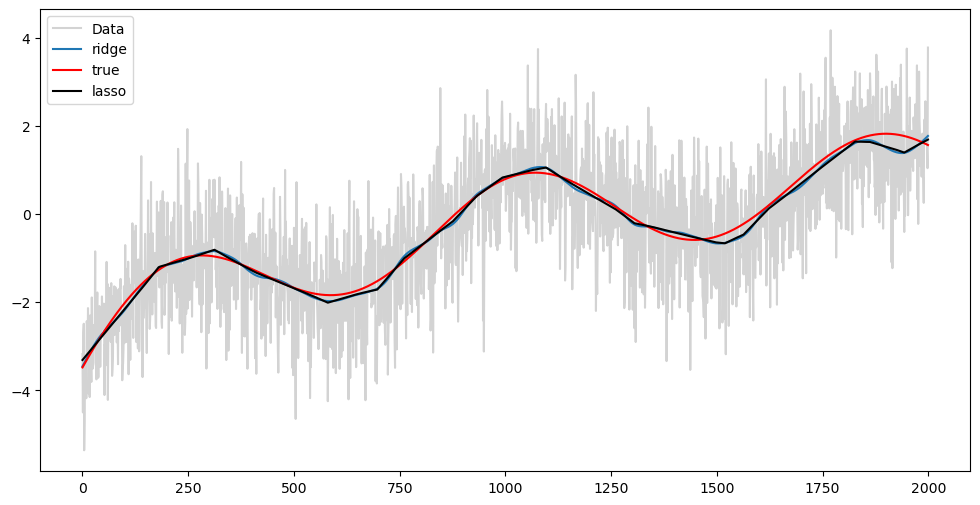

In [218]:
def mu_est_ridge(y, lambda_val):
    n = len(y)
    mu = cp.Variable(n)
    neg_likelihood_term = cp.sum((y - mu)**2)
    smoothness_penalty = cp.sum(cp.square(mu[2:] - 2 * mu[1:-1] + mu[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve()
    return mu.value

def mu_est_lasso(y, lambda_val):
    n = len(y)
    mu = cp.Variable(n)
    neg_likelihood_term = cp.sum((y - mu)**2)
    smoothness_penalty = cp.sum(cp.abs(mu[2:] - 2 * mu[1:-1] + mu[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve()
    return mu.value

mu_opt_ridge = mu_est_ridge(y, 200000)
mu_opt_lasso = mu_est_lasso(y, 200)
plt.figure(figsize = (12, 6))
plt.plot(y, label = 'Data', color = 'lightgray')
plt.plot(mu_opt_ridge, label = 'ridge')
plt.plot(mu_true, color = 'red', label = 'true') 
plt.plot(mu_opt_lasso, color = 'black', label = 'lasso')
plt.legend()
plt.show()

## Model TWO

This is the model 
\begin{equation*}
   y_t \overset{\text{independent}}{\sim} N(0, \tau_t^2) 
\end{equation*}
Negative log-likelihood parametrized by $\alpha_t = \log \tau_t$ is given by
\begin{equation*}
  \sum_{t=1}^n \left(\alpha_t + \frac{y_t^2}{2} e^{-2 \alpha_t} \right)
\end{equation*}
We add regularization and minimize: 
\begin{equation*}
  \sum_{t=1}^n \left(\alpha_t + \frac{y_t^2}{2} e^{-2 \alpha_t} \right) + \lambda \sum_{t=2}^{n-1} \left((\alpha_{t+1} - \alpha_{t})- (\alpha_{t} - \alpha_{t-1})\right)^2
\end{equation*}
or
\begin{equation*}
  \sum_{t=1}^n \left(\alpha_t + \frac{y_t^2}{2} e^{-2 \alpha_t} \right) + \lambda \sum_{t=2}^{n-1} \left|(\alpha_{t+1} - \alpha_{t})- (\alpha_{t} - \alpha_{t-1})\right|
\end{equation*}

In [219]:
def alpha_est_ridge(y, lambda_val):
    n = len(y)
    alpha = cp.Variable(n)
    neg_likelihood_term = cp.sum(cp.multiply(((y ** 2)/2), cp.exp(-2 * alpha)) + alpha)
    smoothness_penalty = cp.sum(cp.square(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve()
    return alpha.value

def alpha_est_lasso(y, lambda_val):
    n = len(y)
    alpha = cp.Variable(n)
    neg_likelihood_term = cp.sum(cp.multiply(((y ** 2)/2), cp.exp(-2 * alpha)) + alpha)
    smoothness_penalty = cp.sum(cp.abs(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve()
    return alpha.value

Below we describe two simulation settings for this model. 

### Simulation 1 for Model 2

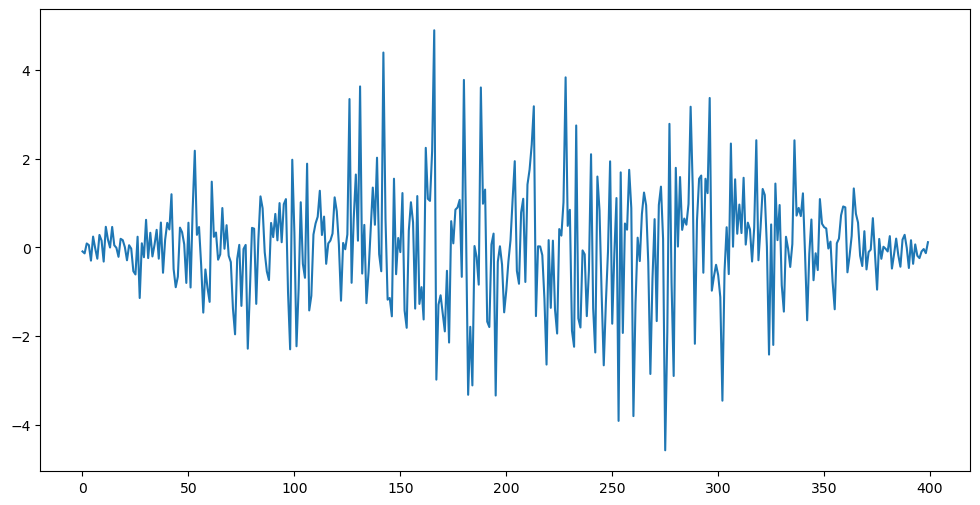

In [220]:
#Simulate data from this variance model:
n = 400
tvals = np.arange(1, n+1)
th = -0.8
tau_t = np.sqrt((1 + (th ** 2) + 2*th*np.cos(2 * np.pi * (tvals)/n))) #this is a smooth function of t
y = rng.normal(loc = 0, scale = tau_t)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

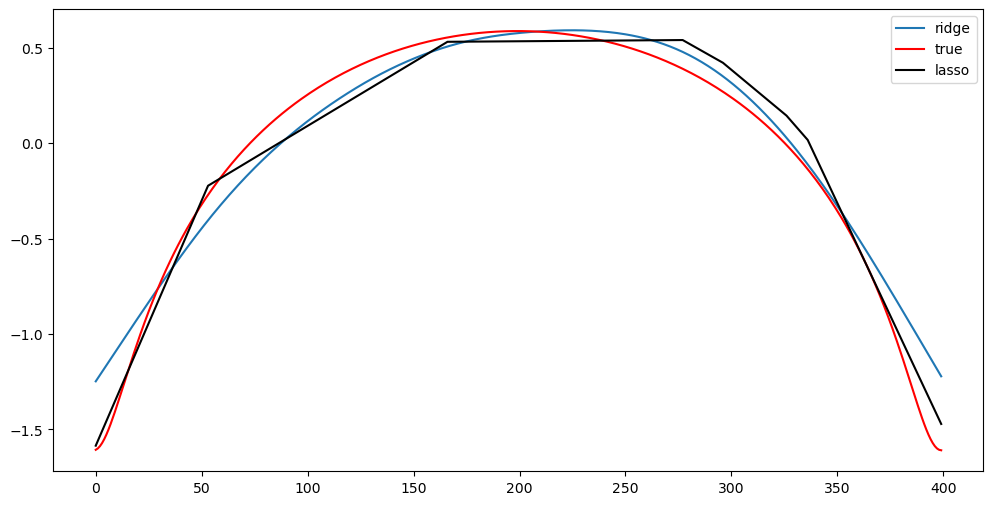

In [221]:
alpha_true = np.log(tau_t)
alpha_opt_ridge = alpha_est_ridge(y, 2000000)
alpha_opt_lasso = alpha_est_lasso(y, 200)
plt.figure(figsize = (12, 6))
plt.plot(alpha_opt_ridge, label = 'ridge')
plt.plot(alpha_true, color = 'red', label = 'true') 
plt.plot(alpha_opt_lasso, color = 'black', label = 'lasso')
plt.legend()
plt.show()

The sufficient statistic in this model is $y_1^2, \dots, y_n^2$. Because $y_t^2 \sim \tau_t^2 \chi^2_1$, the mean of $y_t^2$ equals $\tau_t^2$ and its variance is $2 \tau^4$. Below we plot $y_t^2$ as well as $\tau_t^2$.

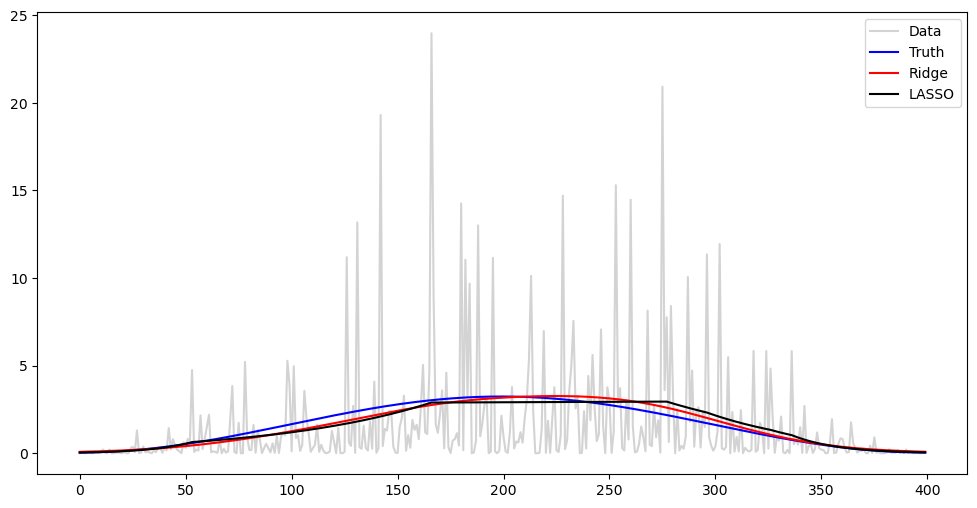

In [222]:
#Plotting y^2 against tau^2
plt.figure(figsize = (12, 6))
plt.plot(y ** 2, label = 'Data', color = 'lightgray')
plt.plot(tau_t ** 2, color = 'blue', label = 'Truth')
plt.plot(np.exp(2*alpha_opt_ridge), color = 'red', label = 'Ridge')
plt.plot(np.exp(2*alpha_opt_lasso), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

Observe from the above plot that both the level (mean) of $y_t^2$ as well as its variance changes with $\tau_t^2$. This is because the mean of $y_t^2$ equals $\tau_t^2$, and its variance equals $2 \tau_t^4$. 

Because $y_t^2 \sim \tau_t^2 \chi^2_1$, we can write
\begin{equation*}
   \log(y_t^2) = \log(\tau_t^2) + \log (\chi^2_1)
\end{equation*}
The mean of $\log \chi^2_1$ is negative (internet says it is about -1.27). This means that if we plot $\log y_t^2$ and $\log \tau_t^2$ in one figure, most of the values for $\log y_t^2$ will appear to be below $\log \tau_t^2$. 

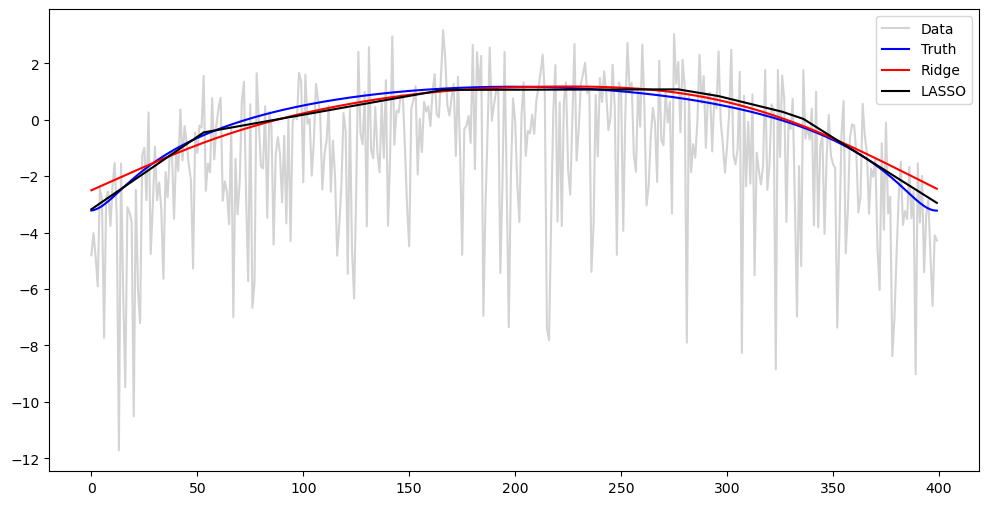

In [223]:
#Plotting log y^2 against log tau^2
plt.figure(figsize = (12, 6))
plt.plot(np.log(y ** 2), color = 'lightgray', label = 'Data')
plt.plot(np.log(tau_t ** 2), color = 'blue', label = 'Truth')
plt.plot(np.log(np.exp(2*alpha_opt_ridge)), color = 'red', label = 'Ridge')
plt.plot(np.log(np.exp(2*alpha_opt_lasso)), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

### Simulation 2 for Model 2

Here is the second simulation setting for this model. 

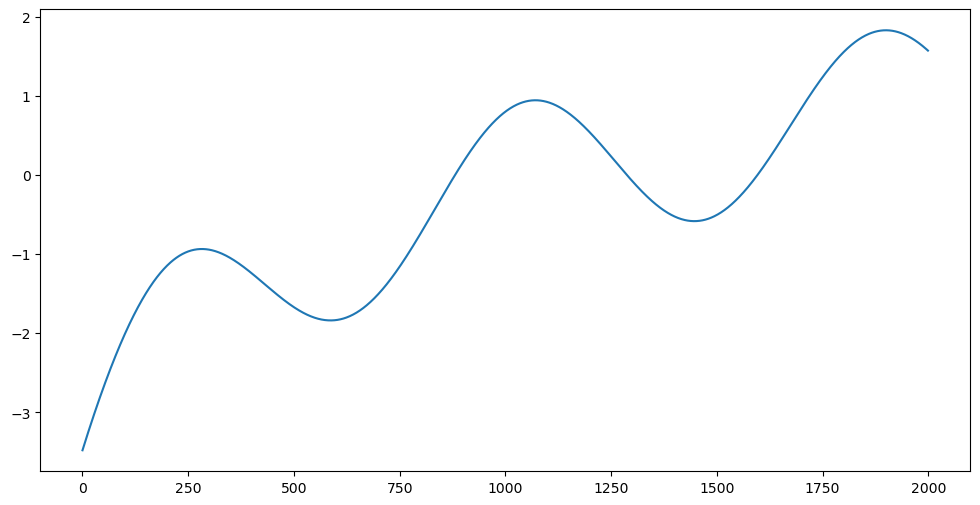

In [224]:
def smoothfun(x):
    ans = np.sin(15*x) + np.exp(-(x ** 2)/2) + 0.5*((x - 0.5) ** 2) + 2*np.log(x + 0.1)
    return ans

n = 2000
xx = np.linspace(0, 1, n)
alpha_true = np.array([smoothfun(x) for x in xx])
plt.figure(figsize = (12, 6))
plt.plot(alpha_true)
plt.show()

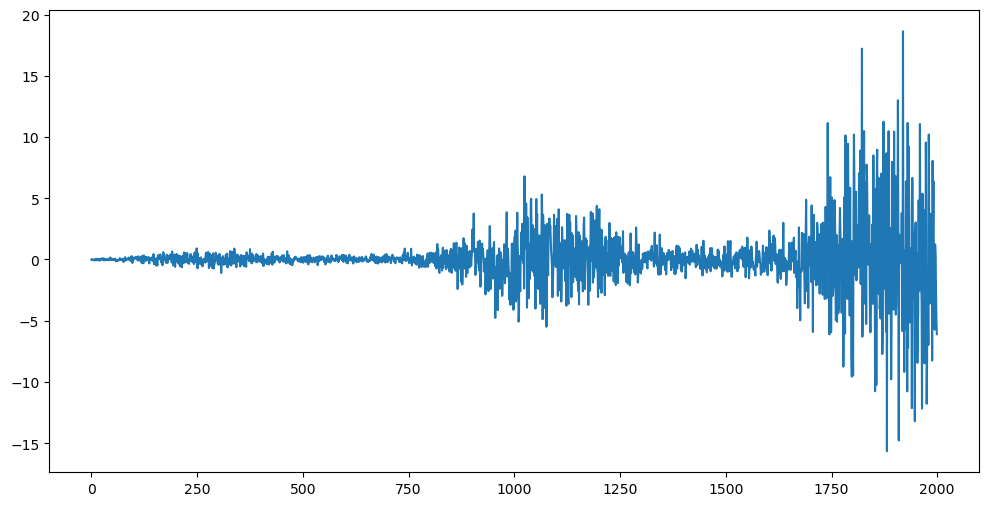

In [225]:
tau_t = np.exp(alpha_true)
y = rng.normal(loc = 0, scale = tau_t)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

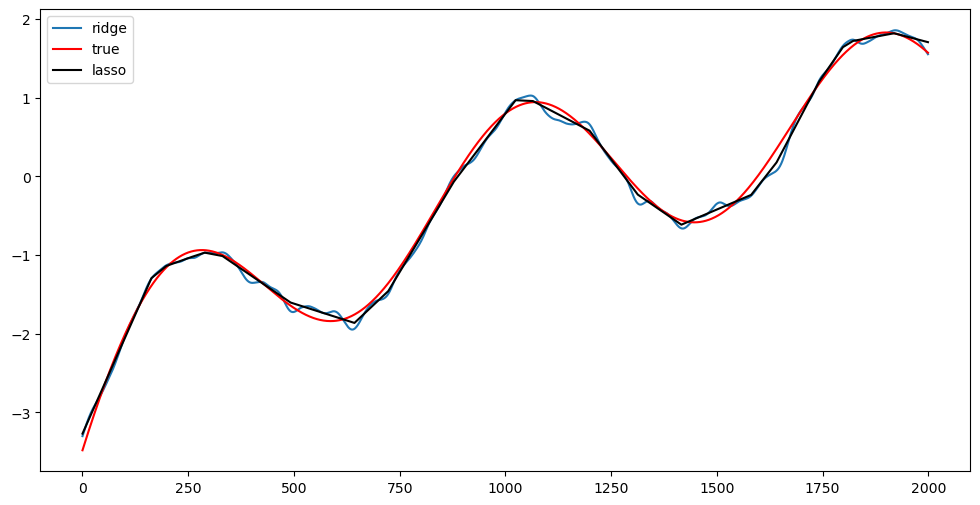

In [226]:
alpha_opt_ridge = alpha_est_ridge(y, 40000)
alpha_opt_lasso = alpha_est_lasso(y, 200)
plt.figure(figsize = (12, 6))
plt.plot(alpha_opt_ridge, label = 'ridge')
plt.plot(alpha_true, color = 'red', label = 'true') 
plt.plot(alpha_opt_lasso, color = 'black', label = 'lasso')
plt.legend()
plt.show()

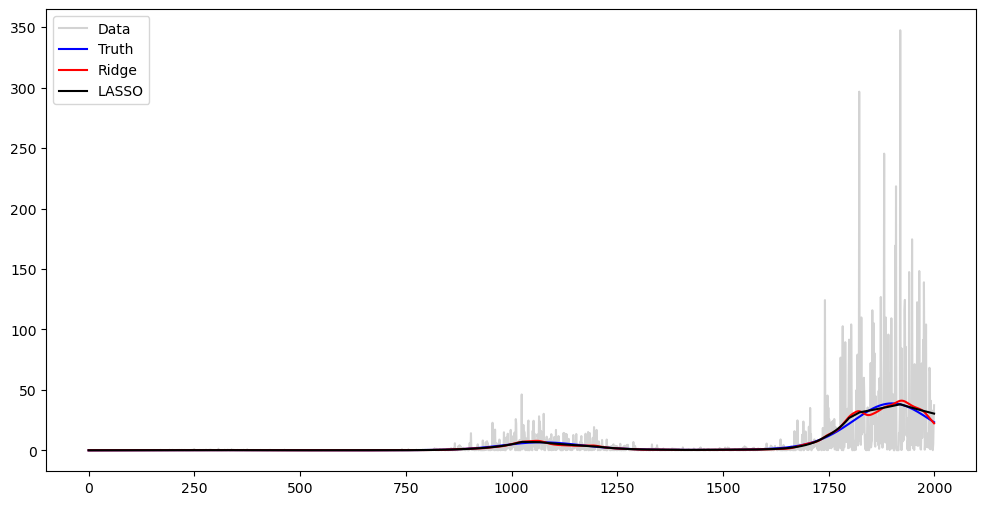

In [227]:
#Plotting y^2 against tau^2
plt.figure(figsize = (12, 6))
plt.plot(y ** 2, label = 'Data', color = 'lightgray')
plt.plot(tau_t ** 2, color = 'blue', label = 'Truth')
plt.plot(np.exp(2*alpha_opt_ridge), color = 'red', label = 'Ridge')
plt.plot(np.exp(2*alpha_opt_lasso), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

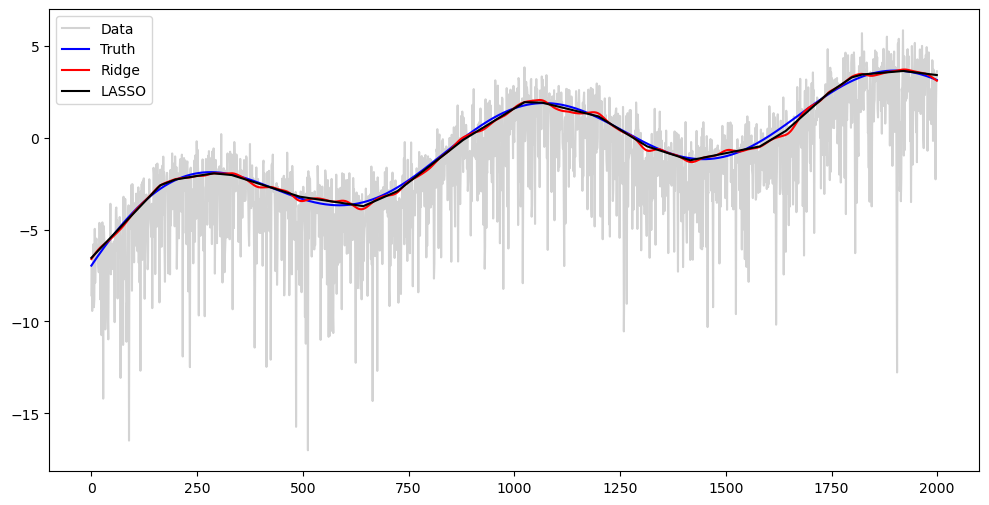

In [228]:
#Plotting log y^2 against log tau^2
plt.figure(figsize = (12, 6))
plt.plot(np.log(y ** 2), color = 'lightgray', label = 'Data')
plt.plot(np.log(tau_t ** 2), color = 'blue', label = 'Truth')
plt.plot(np.log(np.exp(2*alpha_opt_ridge)), color = 'red', label = 'Ridge')
plt.plot(np.log(np.exp(2*alpha_opt_lasso)), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

### A real dataset from finance for which Model 2 is applicable

Next, we examine a real dataset where this variance model (Model 2) may be applicable. The dataset consists of stock price data for the S&P 500 mutual fund, downloaded from Yahoo Finance using the yfinance library.

[*********************100%***********************]  1 of 1 completed


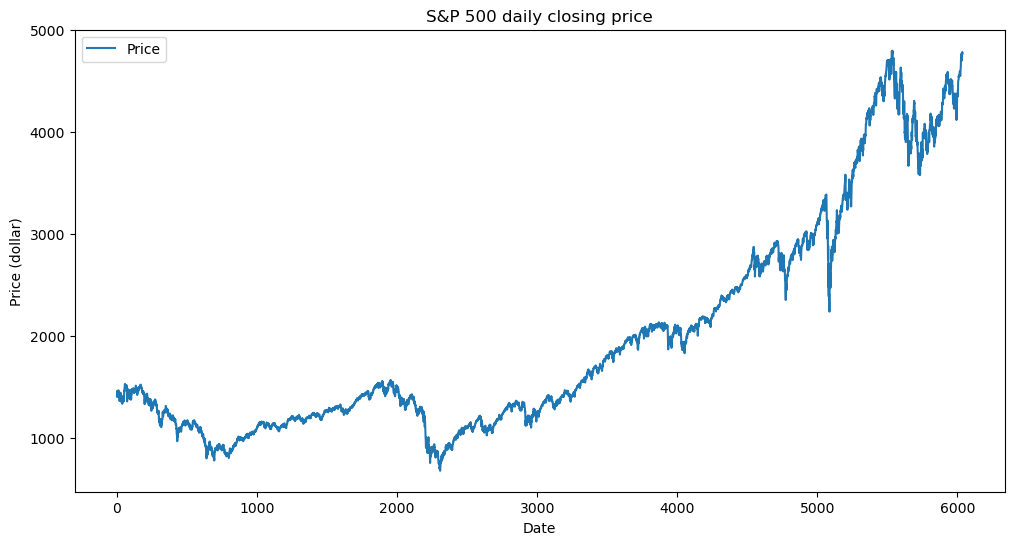

In [230]:
# Download S&P 500 data
sp500 = yf.download('^GSPC', start='2000-01-01', end='2024-01-01')

sp500_closeprice = sp500['Close'].to_numpy().flatten() #this is the daily closing price of the S&P 500 index

plt.figure(figsize=(12,6))
plt.plot(sp500_closeprice, label="Price")
plt.xlabel("Date")
plt.title("S&P 500 daily closing price")
plt.ylabel("Price (dollar)")
plt.legend()
plt.show()


Instead of working with the prices directly, we work with percentage daily returns. 

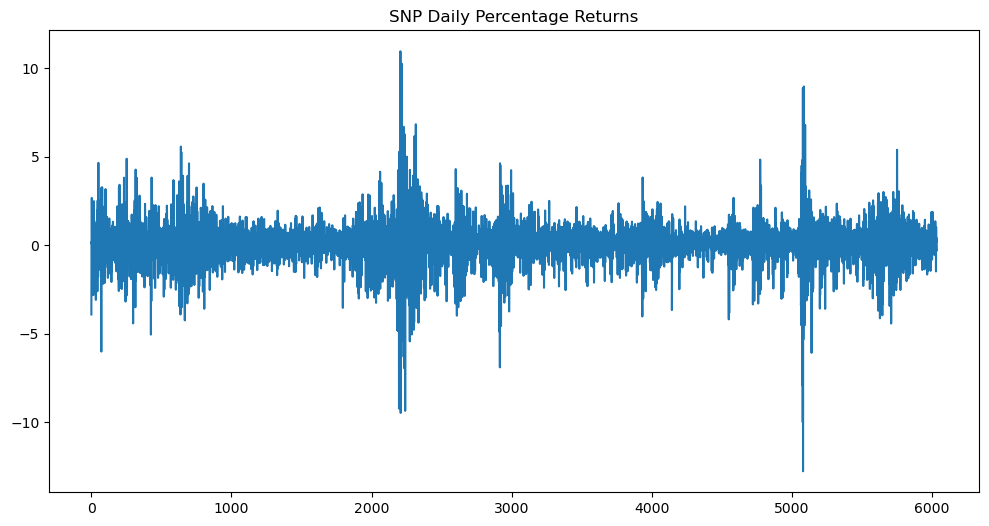

In [237]:
log_prices = np.log(sp500_closeprice)
y = 100 * np.diff(log_prices) #these are the percentage daily returns
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.title('SNP Daily Percentage Returns')
plt.show()

The plot above suggests that Model 2 might be useful for this dataset. 

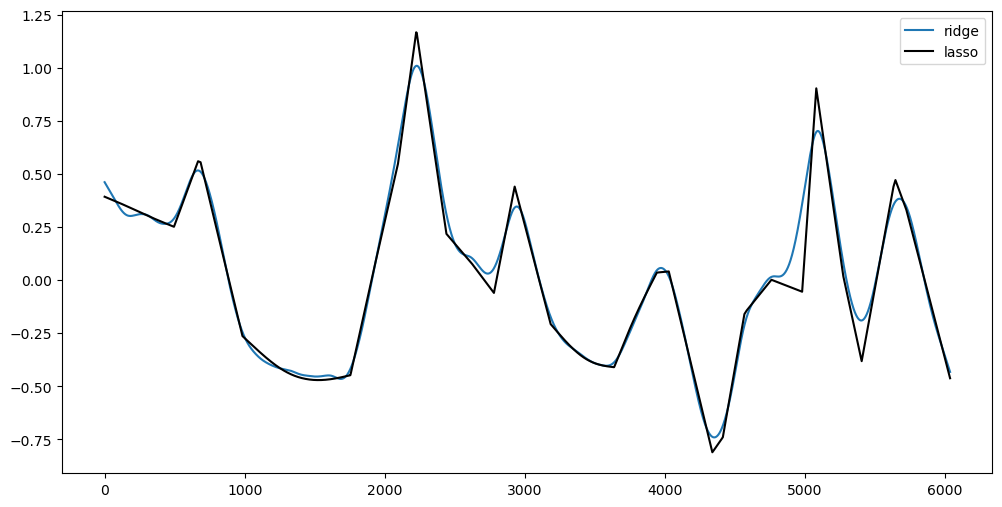

In [233]:
alpha_opt_ridge = alpha_est_ridge(y, 40000000)
alpha_opt_lasso = alpha_est_lasso(y, 2000)
plt.figure(figsize = (12, 6))
plt.plot(alpha_opt_ridge, label = 'ridge')
plt.plot(alpha_opt_lasso, color = 'black', label = 'lasso')
plt.legend()
plt.show()

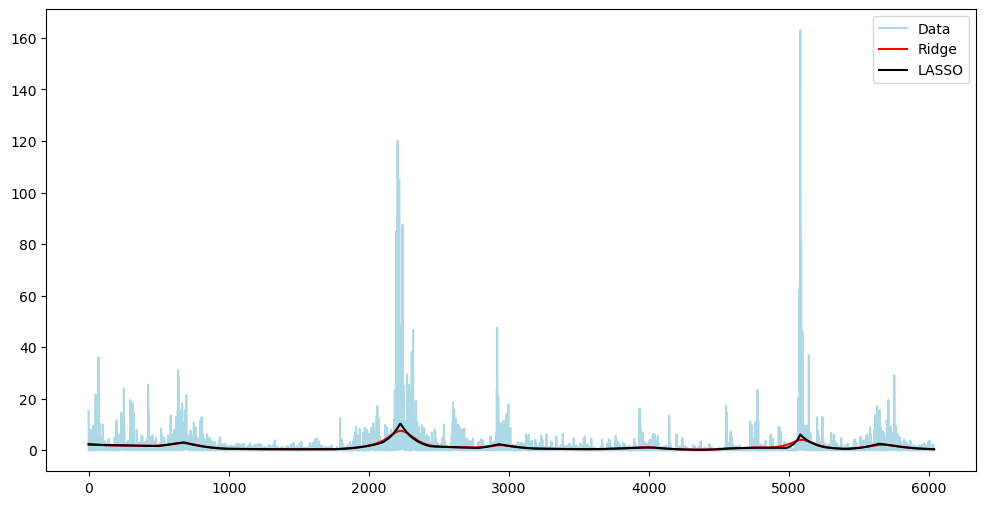

In [234]:
#Plotting y^2 against tau^2
plt.figure(figsize = (12, 6))
plt.plot(y ** 2, label = 'Data', color = 'lightblue')
plt.plot(np.exp(2*alpha_opt_ridge), color = 'red', label = 'Ridge')
plt.plot(np.exp(2*alpha_opt_lasso), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

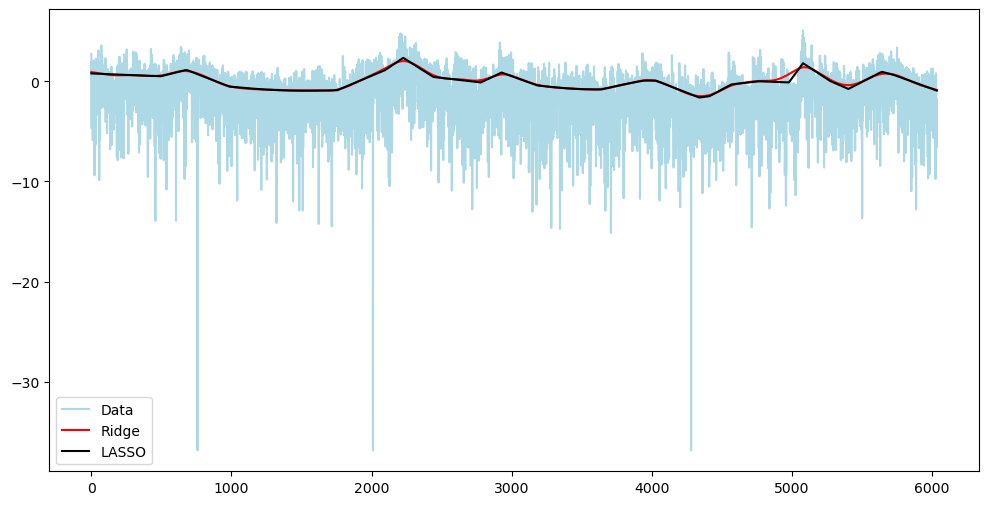

In [235]:
#Plotting log y^2 against log tau^2
plt.figure(figsize = (12, 6))
plt.plot(2*np.log(np.abs(y) + 1e-8), color = 'lightblue', label = 'Data') #small value added to np.abs(y) to prevent taking logs of zeros
plt.plot(np.log(np.exp(2*alpha_opt_ridge)), color = 'red', label = 'Ridge')
plt.plot(np.log(np.exp(2*alpha_opt_lasso)), color = 'black', label = 'LASSO')
plt.legend()
plt.show()

## Model THREE

Model 3 is
\begin{equation*}
    \text{Re}(b_j), \text{Im}(b_j) \overset{\text{i.i.d}}{\sim} N(0, \gamma_j^2)
\end{equation*}
for $j = 1, \dots, m$ where $b_j$ is the $j^{th}$ DFT coefficient of the observed data $y_1, \dots, y_n$. 

Likelihood in terms of the periodogram is: 
\begin{equation*}
   \prod_{j=1}^m \frac{n}{\gamma_j^2} \exp \left(-\frac{n I(j/n)}{2 \gamma_j^2} \right)
\end{equation*}
Negative log-likelihood is
\begin{equation*}
  \sum_{j=1}^m \left(\frac{n I(j/n)}{2 \gamma_j^2} +  2 \log \gamma_j \right)
\end{equation*}
Letting $\alpha_j = \log \gamma_j$, we can rewrite the above as
\begin{equation*}
\sum_{j=1}^m \left( \frac{nI(j/n)}{2} e^{-2 \alpha_j} + 2 \alpha_j \right)
\end{equation*}
Minimizing this without any regularization on $\{\alpha_j\}$ leads to
\begin{equation*}
    \alpha_j = \log \sqrt{\frac{nI(j/n)}{2}} ~~ \text{ and } ~~ \gamma_j^2 = e^{2\alpha_j} = \frac{nI(j/n)}{2}
\end{equation*}
We will use regularization and estimate $\alpha_j$ (and $\gamma_j$) by minimizing:
\begin{equation*}
   \sum_{j=1}^m \left( \frac{nI(j/n)}{2} e^{-2 \alpha_j} + 2 \alpha_j \right)  + \lambda \sum_{j=2}^{m-1} \left((\alpha_{j+1} - \alpha_j) - (\alpha_j - \alpha_{j-1}) \right)^2
\end{equation*}
or
\begin{equation*}
    \sum_{j=1}^m \left( \frac{nI(j/n)}{2} e^{-2 \alpha_j} + 2 \alpha_j \right) + \lambda \sum_{j=2}^{m-1} \left|(\alpha_{j+1} - \alpha_j) - (\alpha_j - \alpha_{j-1}) \right|.
\end{equation*}
Code for computing these estimators is given below. These functions (spectrum_estimator_ridge and spectrum_estimator_lasso) use $y$ and $\lambda$ as input. In the first step, one computes the periodogram $I(j/n)$ as the optimization is in terms of the periodogram. We apply these methods to the sunspots dataset.

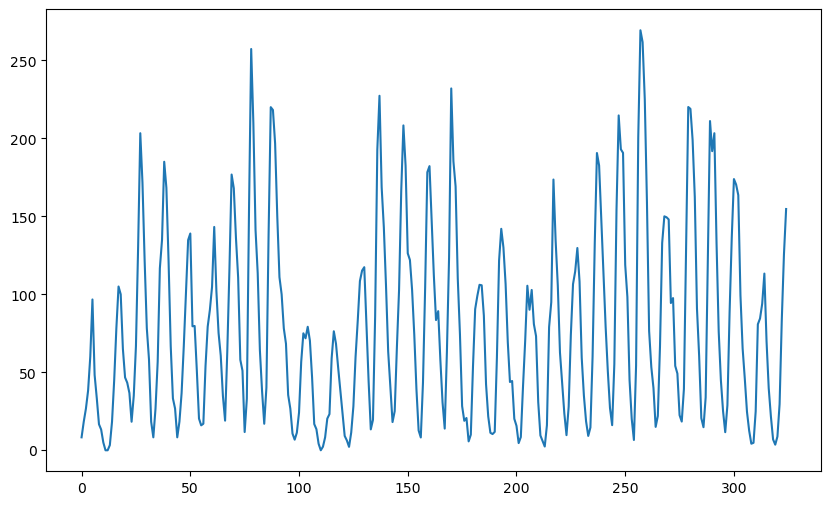

In [238]:
sunspots = pd.read_csv('SN_y_tot_V2.0.csv', header = None, sep = ';')
y = sunspots.iloc[:,1].values
n = len(y)
plt.figure(figsize = (10, 6))
plt.plot(y)
plt.show()

In [239]:
def periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, 1/2, 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    return fourier_freqs, pgram_y

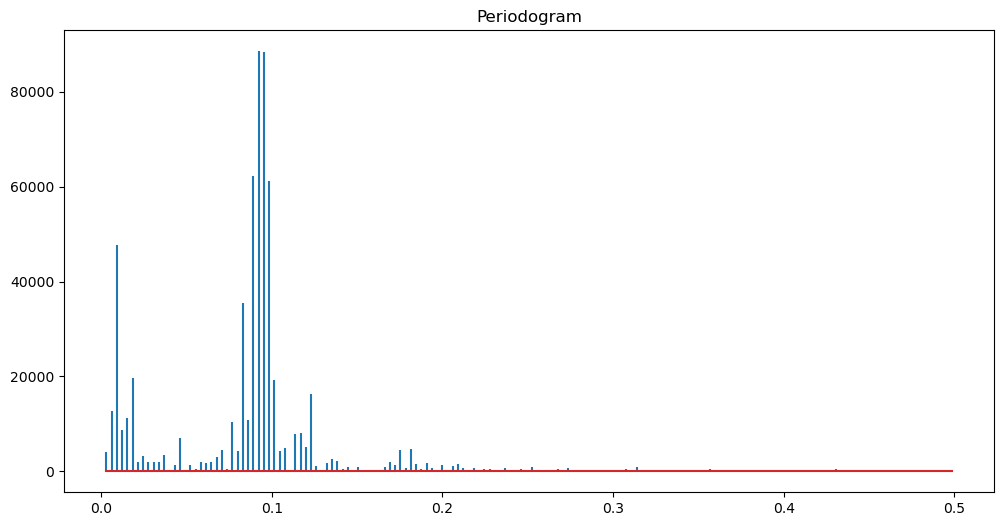

In [240]:
freqs, pgram = periodogram(y)
plt.figure(figsize = (12, 6))
markerline, stemline, baseline = plt.stem(freqs, pgram)
markerline.set_marker("None")
plt.title('Periodogram')
plt.show()

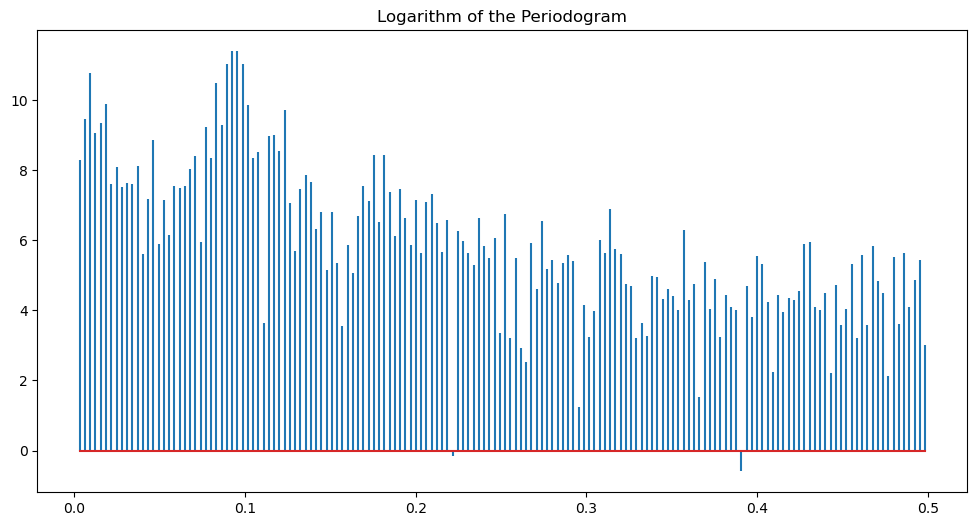

In [241]:
plt.figure(figsize = (12, 6))
markerline, stemline, baseline = plt.stem(freqs, np.log(pgram))
markerline.set_marker("None")
plt.title('Logarithm of the Periodogram')
plt.show()

In [242]:
def spectrum_estimator_ridge(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y)
    alpha = cp.Variable(m)
    neg_likelihood_term = cp.sum(cp.multiply((n * I / 2), cp.exp(-2 * alpha)) + 2*alpha)
    smoothness_penalty = cp.sum(cp.square(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve()
    return alpha.value, freq

def spectrum_estimator_lasso(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y) 
    alpha = cp.Variable(m)
    neg_likelihood_term = cp.sum(cp.multiply((n * I / 2), cp.exp(-2 * alpha)) + 2*alpha)
    smoothness_penalty = cp.sum(cp.abs(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))
    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve()
    return alpha.value, freq

After computing the estimators using the above code, we can the periodogram and its logarithm along with suitable estimates. The mean of $I(j/n)$ according to the model is 
\begin{equation*}
  \mathbb{E} I(j/n) = \frac{2 \gamma_j^2}{n} = \frac{2}{n} e^{2 \alpha_j}
\end{equation*}

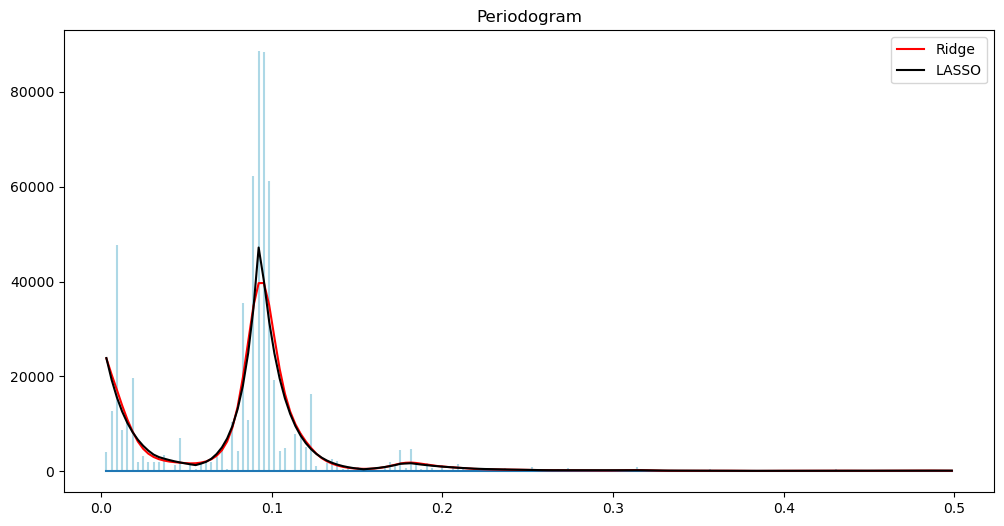

In [243]:
alpha_opt_ridge, freq = spectrum_estimator_ridge(y, 100)
pgram_mean_ridge = (2/n)*(np.exp(2*alpha_opt_ridge))
alpha_opt_lasso, freq = spectrum_estimator_lasso(y, 10)
pgram_mean_lasso = (2/n)*(np.exp(2*alpha_opt_lasso))

plt.figure(figsize = (12, 6))
markerline, stemline, baseline = plt.stem(freq, pgram, linefmt = 'lightblue', basefmt = '')
markerline.set_marker("None")
plt.title('Periodogram')
plt.plot(freq, pgram_mean_ridge, color = 'red', label = 'Ridge')
plt.plot(freq, pgram_mean_lasso, color = 'black', label = "LASSO")
plt.legend()
plt.show()


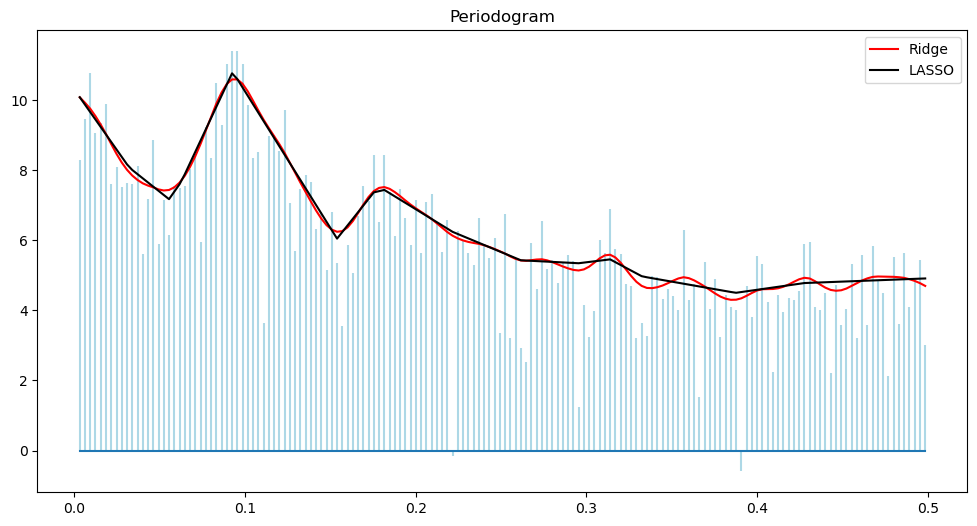

In [244]:
plt.figure(figsize = (12, 6))
markerline, stemline, baseline = plt.stem(freq, np.log(pgram), linefmt = 'lightblue', basefmt = '')
markerline.set_marker("None")
plt.title('Periodogram')
plt.plot(freq, np.log(pgram_mean_ridge), color = 'red', label = 'Ridge')
plt.plot(freq, np.log(pgram_mean_lasso), color = 'black', label = "LASSO")
plt.legend()
plt.show()
